# Sentinel-1 Monthly Mosaic <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[s1_monthly_mosaic](https://explorer.digitalearth.africa/products/s1_monthly_mosaic)

## Background

Synthetic Aperture Radar (SAR) sensor has the advantage of operating at wavelengths not impeded by cloud cover and can acquire data over a site during the day or night. The [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1)  mission, part of the Copernicus joint initiative by the European Commission (EC) and the European Space Agency (ESA), provides reliable and repeated wide-area monitoring using its SAR instrument.

Sentinel-1 monthly mosaics are generated from Radiometric Terrain Corrected (RTC) backscatter data, with variations from changing observation geometries mitigated. RTC images acquired within a calendar month are combined using a multitemporal compositing algorithm. This algorithm calculates a weighted average of valid pixels, assigning higher weights to pixels with higher local resolution (e.g., slopes facing away from the sensor). This local resolution weighting approach minimizes noise and improves spatial homogeneity in the composites. 

More information on how the product is generated can be found in the [Copernicus Data Space Ecosystem Documentation](https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel1.html#sentinel-1-level-3-monthly-mosaics)


DE Africa provides access to Sentinel-1 monthly mosaics generated from Interferometric Wide (IW) acquisition mode. The mosaics are organized in a UTM grid with tiles measuring 100 x 100 km and have a spatial resolution of 20 meters.

## Description

In this notebook we will load Sentinel-1 Monthly Mosaics.

Topics covered include:
1. Inspecting the Sentinel-1 monthly mosaics product and measurements available in the datacube
2. Using the `dc.load()` function to load in Sentinel-1 monthly mosaics
3. Visualising and comparing monthly mosaic with individual Sentinel-1 scenes
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline
import datacube
import sys
import math 
import numpy as np
import matplotlib.pyplot as plt
from deafrica_tools.plotting import rgb 
from deafrica_tools.plotting import display_map
from deafrica_tools.datahandling import mostcommon_crs

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Sentinel_1_mosaic")

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's Sentinel-1 products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
dc.list_products().loc[dc.list_products()['name'].str.contains('s1')]

,name,description,license,default_crs,default_resolution
name,,,,,
s1_monthly_mosaic,s1_monthly_mosaic,Monthly Sentinel-1 mosaics of weighted terrain...,None,None,None
s1_rtc,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,CC-BY-4.0,EPSG:4326,"(-0.0002, 0.0002)"


In [4]:
product = "s1_monthly_mosaic"

### List measurements

We can further inspect the data available for each SAR product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [5]:
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
VV,VV,float32,1,NaN,[vv],NaN
VH,VH,float32,1,NaN,[vh],NaN


The Sentinel-1 Monthly Mosaic product has two measurements:

* Backscatter in `VV` polarisation, representing weighted average of valid normalized `VV` backscatter values measured over the month. 
* Backscatter in `VH` polarisation, representing weighted average of valid normalized `VH` backscatter values measured over the month. 

The two-letter band names indicate the polarization of the light transmitted and received by the satellite. *VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.

## Load Sentinel-1 Monthly Mosaics using `dc.load()`

Now that we know what products and measurements are available for the product, we can load data from the datacube using `dc.load`.

In the example below, we will load Sentinel-1 mosaic near Cape Town, SA from Nov to Dec 2023. 

We will load data from two polarisation bands,`VV` and `VH`. Since the data is provided in UTM grid, we will use the most common projection for the area to load data.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [6]:
# Define the area of interest
latitude = -34.03
longitude = 18.56
latitude = -34.0 
longitude = 18.82

buffer = 0.03
time = ('2023-11', '2023-12')

bands = ['vv','vh']

In [7]:
#add spatio-temporal extent to the query
query = {
    'x': (longitude-buffer, longitude+buffer),
    'y': (latitude+buffer, latitude-buffer),
    'time':time,
}

### Visualise the selected area 

In [8]:
display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

In [9]:
output_crs = mostcommon_crs(dc=dc, product=product, query=query)
print(output_crs)

epsg:32734


In [10]:
# loading the data
ds_monthly = dc.load(
    product=product,
    measurements=bands,
    #output_crs=output_crs,
    output_crs='epsg:6933',
    resolution=(-20, 20),
    **query
)

print(ds_monthly)

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 2, y: 320, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 16B 2023-11-15T23:59:59.500000 2023-12...
  * y            (y) float64 3kB -4.09e+06 -4.09e+06 ... -4.096e+06 -4.096e+06
  * x            (x) float64 2kB 1.813e+06 1.813e+06 ... 1.819e+06 1.819e+06
    spatial_ref  int32 4B 6933
Data variables:
    vv           (time, y, x) float32 745kB 0.1916 0.1465 ... 0.09032 0.1065
    vh           (time, y, x) float32 745kB 0.04568 0.04677 ... 0.01601 0.01947
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Visualise Sentinel-1 Mosaic 

In [11]:
# adding a ratio band
ds_monthly['vh_over_vv'] = ds_monthly.vh/ds_monthly.vv

In [12]:
data_min = ds_monthly.quantile(0.02)
data_max = ds_monthly.quantile(0.98)

In [13]:
scaled = (ds_monthly - data_min)/(data_max - data_min)

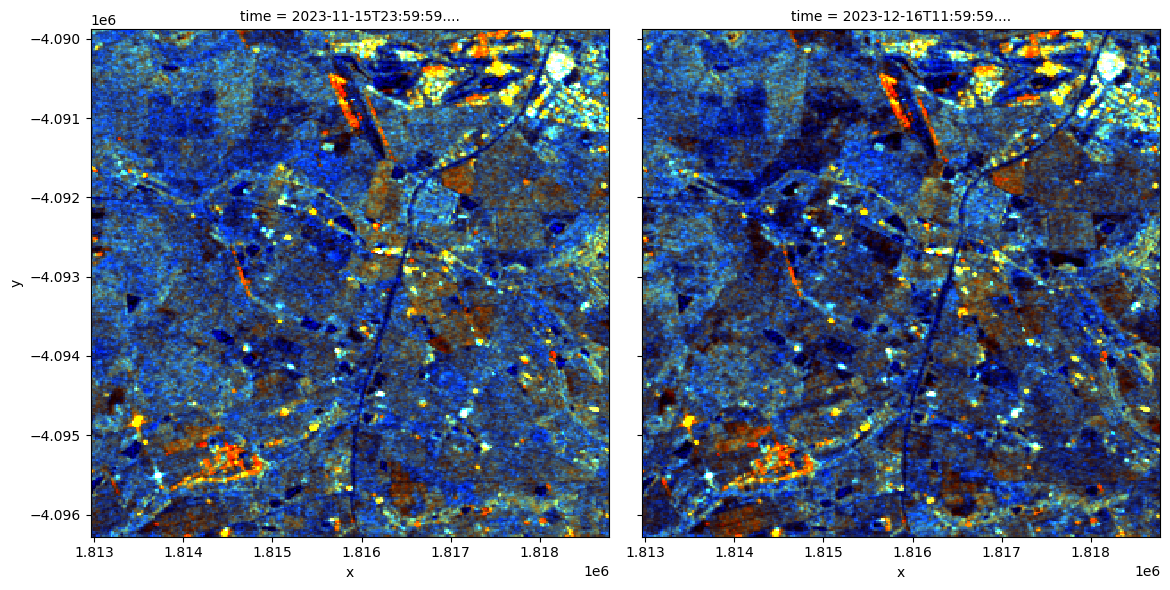

In [14]:
rgb(scaled, bands=['vv','vh','vh_over_vv'], col='time')

## Advantages of using the monthly mosaics

Monthly mosaics offer reduced noise (as shown below) and improved spatial homogeneity compared to individual Sentinel-1 scenes. Their regular monthly spacing enables easy time series analysis, either alone or combined with other datasets.

In [15]:
# loading individual Sentinel-1 scenes
ds_S1 = dc.load(product='s1_rtc',
                measurements=bands, # + ['mask', 'area'],
                group_by="solar_day",
                output_crs = ds_monthly.attrs['crs'], resolution = (-20,20),
                dask_chunks = {},
                **query)

print(ds_S1)

<xarray.Dataset> Size: 8MB
Dimensions:      (time: 11, y: 320, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 88B 2023-11-01T17:34:31.088766 ... 202...
  * y            (y) float64 3kB -4.09e+06 -4.09e+06 ... -4.096e+06 -4.096e+06
  * x            (x) float64 2kB 1.813e+06 1.813e+06 ... 1.819e+06 1.819e+06
    spatial_ref  int32 4B 6933
Data variables:
    vv           (time, y, x) float32 4MB dask.array<chunksize=(1, 320, 291), meta=np.ndarray>
    vh           (time, y, x) float32 4MB dask.array<chunksize=(1, 320, 291), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


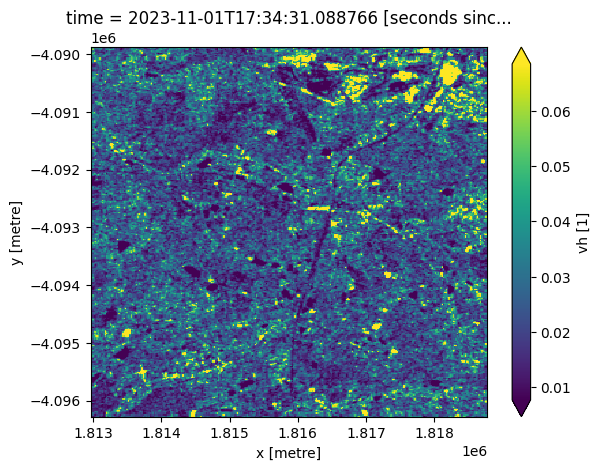

In [16]:
# Plot individual Sentinel-1 observation
ds_S1.vh.isel(time=0).plot.imshow(robust=True)

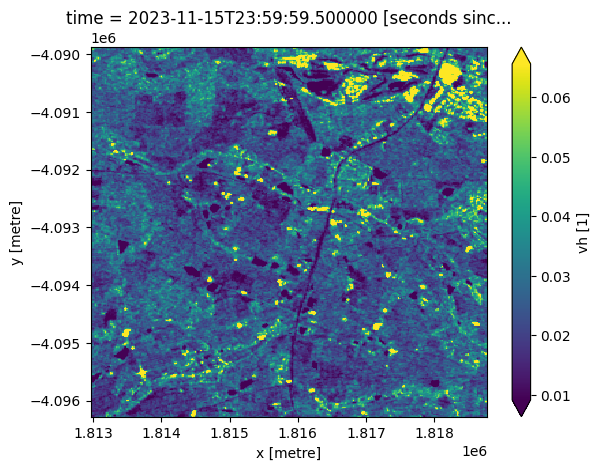

In [17]:
# monthly mosaic
ds_monthly.isel(time=0).vh.plot.imshow(robust=True)

In [18]:
ds = dc.load(product="gm_s2_rolling",
             measurements=['red','green','blue','nir','emad', 'smad', 'bcmad'],
             output_crs = ds_monthly.attrs['crs'], resolution = (-20,20),
             **query)

In [19]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 1, y: 320, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 8B 2023-10-16T11:59:59.999999
  * y            (y) float64 3kB -4.09e+06 -4.09e+06 ... -4.096e+06 -4.096e+06
  * x            (x) float64 2kB 1.813e+06 1.813e+06 ... 1.819e+06 1.819e+06
    spatial_ref  int32 4B 6933
Data variables:
    red          (time, y, x) uint16 186kB 175 183 153 183 ... 902 953 955 915
    green        (time, y, x) uint16 186kB 277 302 255 288 ... 756 777 778 759
    blue         (time, y, x) uint16 186kB 96 112 84 104 102 ... 453 462 453 441
    nir          (time, y, x) uint16 186kB 2146 2500 2474 ... 2629 2578 2613
    emad         (time, y, x) float32 372kB 1.141e+03 1.072e+03 ... 228.6 262.0
    smad         (time, y, x) float32 372kB 0.001049 0.0005426 ... 0.0003264
    bcmad        (time, y, x) float32 372kB 0.1203 0.1002 ... 0.0168 0.01936
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

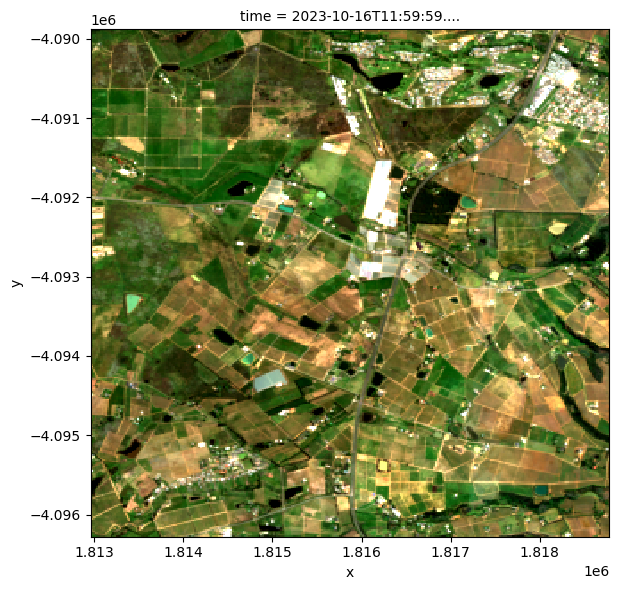

In [20]:
rgb(ds, col='time')

## Generating weighted mosaic

In [21]:
ds_S1

<xarray.Dataset> Size: 8MB
Dimensions:      (time: 11, y: 320, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 88B 2023-11-01T17:34:31.088766 ... 202...
  * y            (y) float64 3kB -4.09e+06 -4.09e+06 ... -4.096e+06 -4.096e+06
  * x            (x) float64 2kB 1.813e+06 1.813e+06 ... 1.819e+06 1.819e+06
    spatial_ref  int32 4B 6933
Data variables:
    vv           (time, y, x) float32 4MB dask.array<chunksize=(1, 320, 291), meta=np.ndarray>
    vh           (time, y, x) float32 4MB dask.array<chunksize=(1, 320, 291), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [ ]:
weight = 1/ds_S1.area.where(ds_S1.mask==1)
ds_S1_weighted = (ds_S1[['vv', 'vh']].where(ds_S1.mask==1)*weight/weight.sum(dim='time')).sum(dim='time')

In [ ]:
ds_S1_weighted.mean(), ds_monthly.mean()

In [ ]:
(ds_S1_weighted.squeeze().vv-ds_monthly.squeeze().vv).plot.imshow(robust=True)

In [ ]:
((ds_S1_weighted.squeeze().vv-ds_monthly.squeeze().vv)/ds_monthly.squeeze().vv).plot.imshow(robust=True)

## Other considerations

Combining acquisitions from different orbit directions and look angles can reduce radar shadow impacts in mosaics. However, in steep terrain, some areas may consistently fall into radar shadow, preventing reliable backscatter measurements. These areas are marked as NaN in the mosaic.

When high temporal resolution is crucial, individual [Sentinel-1](Sentinel_1.ipynb) scenes offer greater flexibility for analysis.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')